In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

In [ ]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- 1. Define the Fusion Module (Same as Before) ---


In [ ]:
import torch
import torch.nn as nn

class GatedCrossAttentionFusion(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        self.gate_proj     = nn.Linear(d_model, d_model)
        self.unstable_proj = nn.Linear(d_model, d_model)
        self.out_proj      = nn.Linear(d_model, d_model)

    def forward(self, primary: torch.Tensor, auxiliary: torch.Tensor) -> torch.Tensor:
        # 3D handling
        if primary.dim() == 3 and auxiliary.dim() == 3:
            B, L, D = primary.shape
            p_flat = primary.reshape(B*L, D)
            a_flat = auxiliary.reshape(B*L, D)
            fused  = self._fuse_2d(p_flat, a_flat)
            return fused.view(B, L, D)

        # 2D handling
        if primary.dim() == 2 and auxiliary.dim() == 2:
            return self._fuse_2d(primary, auxiliary)

        raise ValueError(f"Unsupported dims: {primary.dim()}, {auxiliary.dim()}")

    def _fuse_2d(self, p: torch.Tensor, a: torch.Tensor) -> torch.Tensor:
        # Q/K/V projections
        Q = self.q_proj(p).view(-1, self.n_heads, self.head_dim)
        K = self.k_proj(a).view(-1, self.n_heads, self.head_dim)
        V = self.v_proj(a).view(-1, self.n_heads, self.head_dim)

        # Scaled dot‐product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (N, H, H)
        # <-- use torch.softmax directly, not F.softmax
        weights = torch.softmax(scores, dim=-1)
        attn    = torch.matmul(weights, V).view(-1, self.d_model)

        # Gated fusion
        unstable = self.unstable_proj(attn)
        gate     = torch.sigmoid(self.gate_proj(p))
        fused    = unstable * gate

        return self.out_proj(fused)


In [ ]:
class MSGCAFusion(nn.Module):

    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.f = GatedCrossAttentionFusion(d_model, n_heads)

    def forward(self, indicators: Tensor, documents: Tensor) -> Tensor:
        return self.f(indicators, documents)  # always 2D (B, d_model)

# --- 2. Add a Prediction Head for Stock Movement ---


In [ ]:
class DeepIndicatorEncoder(nn.Module):
    def __init__(self, input_dim: int, d_model: int, n_layers: int = 3, n_heads: int = 4):
        super().__init__()
        self.linear = nn.Linear(input_dim, d_model)
        layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
    def forward(self, x: Tensor) -> Tensor:
        return self.encoder(self.linear(x))  # (B, L, d_model)

In [ ]:
class StockPredictor(nn.Module):

    def __init__(self,
                 feature_dim: int = 5,
                 d_model: int = 64,
                 doc_dim: int = 64,
                 n_heads: int = 4,
                 num_classes: int = 4):
        super().__init__()
        self.enc   = DeepIndicatorEncoder(feature_dim, d_model)
        # Project doc_dim to d_model (works on 2D or 3D)
        self.docp  = nn.Linear(doc_dim, d_model)
        self.fuse  = MSGCAFusion(d_model, n_heads)
        self.head  = nn.Linear(d_model, num_classes)

    def forward(self, indicators: Tensor, documents: Tensor) -> Tensor:
        ie = self.enc(indicators)            # (B, L, d_model)
        de = self.docp(documents)            # (B, d_model) or (B, L, d_model)
        fused = self.fuse(ie, de)            # (B, d_model)
        return self.head(fused)              # (B, num_classes)

In [ ]:
class GatedStockPredictor(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.encoder = IndicatorEncoder(5, d_model)
        self.fusion = MSGCAFusion(d_model, n_heads)

        self.time_mlp = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Linear(d_model // 2, 1)
        )

        self.pred_head = nn.Linear(d_model, 4)  # or 2 if binary

        # Learnable gates for modality contributions
        self.ohlcv_gate = nn.Parameter(torch.tensor(1.0))
        self.doc_gate = nn.Parameter(torch.tensor(0.0))
        self.graph_gate = nn.Parameter(torch.tensor(0.0))

    def forward(self, ohlcv, doc):
        ohlcv_emb = self.encoder(ohlcv)

        # Apply attention fusion
        fused = self.fusion(ohlcv_emb, doc)

        # Combine with gated modality contributions
        combined = fused

        # Compute temporal attention
        scores = self.time_mlp(combined)
        attn = torch.softmax(scores, dim=1)
        pooled = (combined * attn).sum(dim=1)

        return self.pred_head(pooled)


# --- 3. Generate Dummy Data ---


In [ ]:
class DummyStockDataset(Dataset):

    def __init__(self, n_samples=1000, seq_len=20, feature_dim=5, doc_dim=64, num_classes=4):
        self.ind = torch.randn(n_samples, seq_len, feature_dim)
        self.doc = torch.randn(n_samples, seq_len, doc_dim)
        self.y   = torch.randint(0, num_classes, (n_samples,))

    def __len__(self): return len(self.y)

    def __getitem__(self, i): return self.ind[i], self.doc[i], self.y[i]

In [ ]:
from torch.utils.data import random_split
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
# Hyperparams
d_model = 64
n_heads = 4
batch_size = 32
num_epochs = 20
lr = 1e-3
# Data
dataset = DummyStockDataset(n_samples=1000, seq_len=20, feature_dim=5, doc_dim=d_model)
train_size = int(0.8 * len(dataset))
train_ds, val_ds = random_split(dataset, [train_size, len(dataset)-train_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
# Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = StockPredictor(feature_dim=5, d_model=d_model, n_heads=n_heads, num_classes=4).to(device)
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
# Loop
for epoch in range(num_epochs):
    model.train(); total_loss = 0
    for ind, doc, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        ind, doc, labels = ind.to(device), doc.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(ind, doc)
        loss = criterion(logits, labels)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader):.4f}")
    # Validation
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for ind, doc, labels in val_loader:
            ind, doc, labels = ind.to(device), doc.to(device), labels.to(device)
            preds = model(ind, doc).argmax(dim=1)
            correct += (preds==labels).sum().item(); total += len(labels)
    print(f"Val Acc: {100*correct/total:.2f}%")
# Save
torch.save(model.state_dict(), "stock_predictor.pt")

Epoch 1/20: 100%|██████████| 25/25 [00:01<00:00, 22.19it/s]


Epoch 1 Loss: 1.3895
Val Acc: 21.50%


Epoch 2/20: 100%|██████████| 25/25 [00:00<00:00, 55.65it/s]


Epoch 2 Loss: 1.3856
Val Acc: 22.00%


Epoch 3/20: 100%|██████████| 25/25 [00:00<00:00, 56.48it/s]


Epoch 3 Loss: 1.3708
Val Acc: 24.00%


Epoch 4/20: 100%|██████████| 25/25 [00:00<00:00, 45.70it/s]


Epoch 4 Loss: 1.3375
Val Acc: 24.50%


Epoch 5/20: 100%|██████████| 25/25 [00:00<00:00, 49.17it/s]


Epoch 5 Loss: 1.3007
Val Acc: 27.00%


Epoch 6/20: 100%|██████████| 25/25 [00:00<00:00, 77.88it/s]


Epoch 6 Loss: 1.2384
Val Acc: 24.00%


Epoch 7/20: 100%|██████████| 25/25 [00:00<00:00, 69.25it/s]


Epoch 7 Loss: 1.1467
Val Acc: 27.00%


Epoch 8/20: 100%|██████████| 25/25 [00:00<00:00, 64.38it/s]


Epoch 8 Loss: 1.0392
Val Acc: 26.00%


Epoch 9/20: 100%|██████████| 25/25 [00:00<00:00, 100.28it/s]


Epoch 9 Loss: 0.9412
Val Acc: 25.00%


Epoch 10/20: 100%|██████████| 25/25 [00:00<00:00, 101.20it/s]


Epoch 10 Loss: 0.8513
Val Acc: 26.00%


Epoch 11/20: 100%|██████████| 25/25 [00:00<00:00, 101.75it/s]


Epoch 11 Loss: 0.7655
Val Acc: 22.50%


Epoch 12/20: 100%|██████████| 25/25 [00:00<00:00, 93.70it/s]


Epoch 12 Loss: 0.6896
Val Acc: 22.00%


Epoch 13/20: 100%|██████████| 25/25 [00:00<00:00, 101.93it/s]


Epoch 13 Loss: 0.6220
Val Acc: 25.00%


Epoch 14/20: 100%|██████████| 25/25 [00:00<00:00, 102.24it/s]


Epoch 14 Loss: 0.5570
Val Acc: 23.50%


Epoch 15/20: 100%|██████████| 25/25 [00:00<00:00, 93.09it/s]


Epoch 15 Loss: 0.4794
Val Acc: 22.00%


Epoch 16/20: 100%|██████████| 25/25 [00:00<00:00, 94.66it/s]


Epoch 16 Loss: 0.4097
Val Acc: 23.00%


Epoch 17/20: 100%|██████████| 25/25 [00:00<00:00, 101.53it/s]


Epoch 17 Loss: 0.3544
Val Acc: 26.50%


Epoch 18/20: 100%|██████████| 25/25 [00:00<00:00, 100.03it/s]


Epoch 18 Loss: 0.3418
Val Acc: 23.50%


Epoch 19/20: 100%|██████████| 25/25 [00:00<00:00, 98.14it/s]


Epoch 19 Loss: 0.3182
Val Acc: 25.50%


Epoch 20/20: 100%|██████████| 25/25 [00:00<00:00, 93.79it/s]

Epoch 20 Loss: 0.2663
Val Acc: 24.00%


# Synthetic OHLCV Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
def generate_synthetic_ohlcv(num_days=365, initial_price=100, volatility=0.02,
                           volume_base=10000, trend_direction='up', slope=2):
    """
    Generate synthetic OHLCV data with controllable trend direction.

    Parameters:
    - num_days: Number of days to generate data for
    - initial_price: Starting price
    - volatility: Daily price fluctuation factor
    - volume_base: Base volume level
    - trend_direction: 'up' for upward trend, 'down' for downward trend

    Returns:
    - DataFrame with OHLCV data
    """

    # Validate trend direction input
    trend_direction = trend_direction.lower()
    if trend_direction not in ['up', 'down']:
        raise ValueError("trend_direction must be either 'up' or 'down'")

    # Create date range (fixed to exactly num_days)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=num_days-1)  # Adjusted to get exactly num_days
    dates = pd.date_range(start_date, end_date, freq='D')

    # Verify date range length matches num_days
    if len(dates) != num_days:
        raise ValueError(f"Date range length ({len(dates)}) doesn't match num_days ({num_days})")

    # Generate sinusoidal trend with controllable bias
    x = np.linspace(0, 4*np.pi, num_days)
    sine_wave = np.sin(x)

    # Apply trend direction
    if trend_direction == 'up':
        trend = sine_wave + slope*x  # Upward drifting sine wave
    else:
        trend = sine_wave - slope*x  # Downward drifting sine wave

    # Normalize and scale the trend
    trend_min = np.min(trend)
    trend_max = np.max(trend)
    trend = (trend - trend_min) / (trend_max - trend_min)  # Normalize to 0-1
    trend = initial_price * (1 + 0.5 * trend)  # Scale to price range

    # Initialize lists for OHLCV data
    opens = []
    highs = []
    lows = []
    closes = []
    volumes = []

    prev_close = initial_price

    for i in range(num_days):
        # Base price follows the trend
        base_price = trend[i]

        # Generate random daily movement
        daily_move = np.random.normal(0, volatility)
        open_price = prev_close * (1 + 0.5*daily_move)
        close_price = base_price * (1 + daily_move)

        # Generate high and low with some volatility
        intraday_vol = volatility * np.random.random()
        high_price = max(open_price, close_price) * (1 + intraday_vol)
        low_price = min(open_price, close_price) * (1 - intraday_vol)

        # Ensure high > low and they're within reasonable bounds
        high_price = max(high_price, low_price * 1.01)

        # Generate volume correlated with price movement
        volume = volume_base * (1 + 5*abs(daily_move)) * (1 + 0.2*np.sin(i/10))

        opens.append(open_price)
        highs.append(high_price)
        lows.append(low_price)
        closes.append(close_price)
        volumes.append(int(volume))

        prev_close = close_price

    # Create DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Open': opens,
        'High': highs,
        'Low': lows,
        'Close': closes,
        'Volume': volumes
    }, index=range(num_days))

    df.set_index('Date', inplace=True)

    return df

In [ ]:
upward_data = generate_synthetic_ohlcv(trend_direction='up', num_days=100, slope=2)
downward_data = generate_synthetic_ohlcv(trend_direction='down', num_days=100, slope=2)

In [ ]:
upward_data

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-24 08:26:30.005935,100.362397,101.236375,100.234035,100.724794,10362
2025-03-25 08:26:30.005935,101.946257,105.077524,100.092152,103.200605,11436
2025-03-26 08:26:30.005935,102.595244,102.656774,100.258693,100.318858,11007
2025-03-27 08:26:30.005935,101.199697,104.825925,100.445244,104.050221,11520
2025-03-28 08:26:30.005935,102.174947,102.946937,98.525137,99.275219,12721
...,...,...,...,...,...
2025-06-27 08:26:30.005935,143.964542,146.960638,141.330125,144.319722,10751
2025-06-28 08:26:30.005935,144.734014,151.021136,142.369630,148.593700,9928
2025-06-29 08:26:30.005935,147.739025,148.680004,145.847213,146.782096,10000


In [ ]:
downward_data

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-24 08:26:30.026704,99.174857,150.378685,97.256149,147.524570,10825
2025-03-25 08:26:30.026704,146.748791,148.602524,146.322270,148.171867,10736
2025-03-26 08:26:30.026704,151.048396,156.830808,149.553368,155.293760,12415
2025-03-27 08:26:30.026704,157.192992,157.884250,152.201987,152.874252,11886
2025-03-28 08:26:30.026704,155.933719,157.479625,153.373053,154.908798,12936
...,...,...,...,...,...
2025-06-27 08:26:30.026704,102.344980,104.355481,101.008020,103.009836,10803
2025-06-28 08:26:30.026704,103.773138,104.077939,101.968864,102.269248,10366
2025-06-29 08:26:30.026704,101.926657,102.436551,99.337618,99.837059,9773


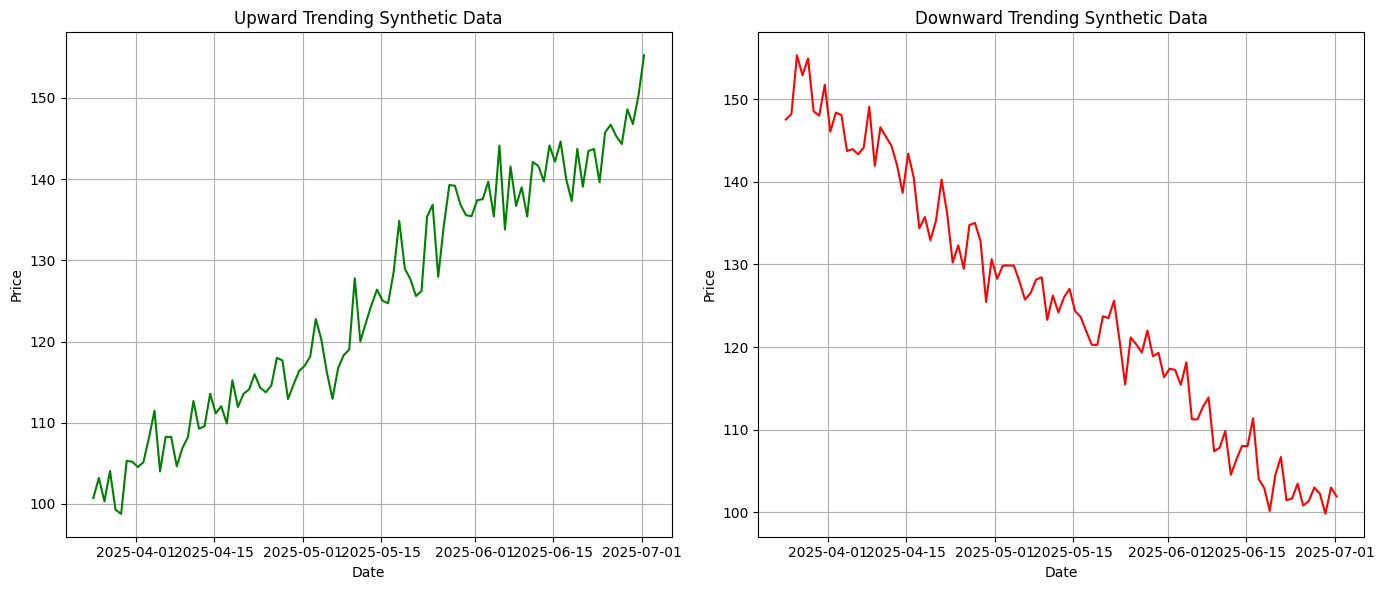

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(upward_data.index, upward_data['Close'], label='Close Price', color='green')
plt.title('Upward Trending Synthetic Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(downward_data.index, downward_data['Close'], label='Close Price', color='red')
plt.title('Downward Trending Synthetic Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize

In [ ]:
def generate_sentiment_embeddings(num_samples=1000, embedding_dim=128, class_separation=2.0, random_state=42):
    """
    Generate synthetic sentiment analysis embeddings with two distinct classes.

    Parameters:
    - num_samples: Total number of samples (half positive, half negative)
    - embedding_dim: Dimension of each embedding vector
    - class_separation: How distinct the clusters should be (higher = more separable)
    - random_state: For reproducibility

    Returns:
    - embeddings: Array of shape (num_samples, embedding_dim)
    - labels: Array of 0s (negative) and 1s (positive)
    - centers: The cluster centers for each class
    """

    # Generate two separable clusters
    centers = np.array([[class_separation] * embedding_dim,
                       [-class_separation] * embedding_dim])

    X, y = make_blobs(n_samples=num_samples,
                      n_features=embedding_dim,
                      centers=centers,
                      cluster_std=1.0,  # Controls spread within each cluster
                      random_state=random_state)

    # Normalize embeddings to unit length
    embeddings = normalize(X)

    # Calculate actual cluster centers (may differ slightly from requested)
    pos_center = embeddings[y == 1].mean(axis=0)
    neg_center = embeddings[y == 0].mean(axis=0)
    actual_centers = np.vstack([neg_center, pos_center])

    return embeddings, y, actual_centers

In [ ]:
# Generate sample data
embeddings, labels, centers = generate_sentiment_embeddings(num_samples=1000, class_separation=1)

# Create a DataFrame for analysis
sentiment_df = pd.DataFrame({
    'embedding': list(embeddings),
    'sentiment': ['positive' if x == 1 else 'negative' for x in labels],
    'label': labels
})

In [ ]:
sentiment_df

,embedding,sentiment,label
0,"[-0.027928653278041095, 0.008319501341267138, ...",negative,0
1,"[0.08218828053630728, 0.1285458630168411, 0.12...",negative,0
2,"[-0.09735285949999893, -0.11983678067361059, -...",positive,1
3,"[-0.07496659474259519, -0.047742397011206444, ...",positive,1
4,"[-0.052401257481429486, -0.06851119897943869, ...",positive,1
...,...,...,...
995,"[0.009676751010964898, 0.006609008728615213, -...",negative,0
996,"[0.11557728140298465, 0.14880151606657063, -0....",negative,0
997,"[-0.07289395739323191, -0.10011754216360162, -...",positive,1
998,"[0.14558860118183461, -0.044536099665803956, 0...",negative,0


In [ ]:
# Visualize with PCA (for 2D visualization)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
def visualize_embeddings(embeddings, labels):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, alpha=0.6, cmap='coolwarm')
    plt.colorbar(scatter, ticks=[0, 1], label='Sentiment (0=negative, 1=positive)')
    plt.title('2D PCA Projection of Sentiment Embeddings')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

    # Plot cluster centers
    centers_2d = pca.transform(centers)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', marker='X', s=200, label='Cluster Centers')
    plt.legend()
    plt.show()

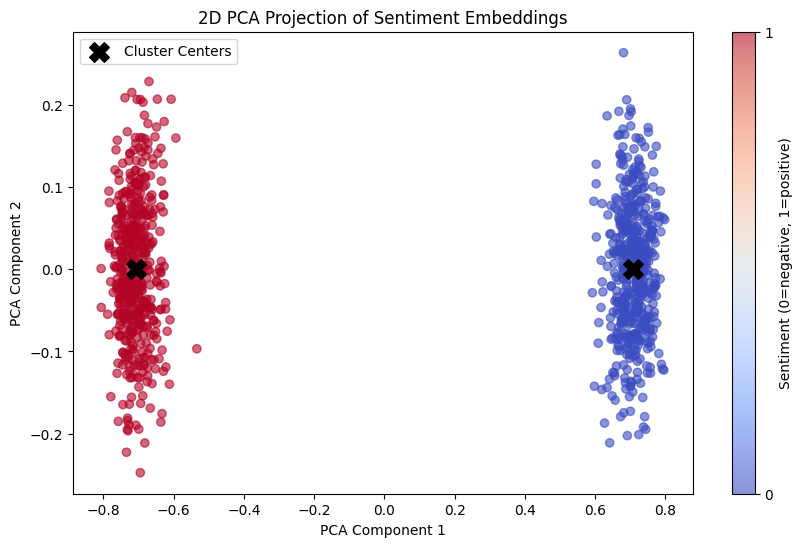

Generated 1000 embeddings (500 positive, 500 negative)
Embedding dimension: 128

Sample embeddings:

Sample labels: [0 0 1 1 1 0 1 0 0 1] ...


In [ ]:
visualize_embeddings(embeddings, labels)

# Sample output
print(f"Generated {len(embeddings)} embeddings ({sum(labels)} positive, {len(labels)-sum(labels)} negative)")
print(f"Embedding dimension: {embeddings.shape[1]}")
print("\nSample embeddings:")
print(pd.DataFrame(embeddings[:3]).style.set_caption("First 3 embeddings (128-dim vectors)"))
print("\nSample labels:", labels[:10], "...")

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch

In [ ]:
def prepare_ohlcv_for_msgca_global(df, window_size=20, scaler=None, return_scaler=False):
    """
    Prepare OHLCV DataFrame into windowed format with global normalization.

    Args:
        df (pd.DataFrame): DataFrame with ['Open', 'High', 'Low', 'Close', 'Volume']
        window_size (int): Size of sliding window
        scaler (MinMaxScaler or StandardScaler): Optional pre-fitted scaler
        return_scaler (bool): Whether to return the fitted scaler for reuse

    Returns:
        torch.Tensor: shape [num_windows, window_size, 5]
        (optional) scaler: the fitted scaler (if return_scaler is True)
    """
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(df.values)  # Fit globally on the whole DataFrame

    normalized_values = scaler.transform(df.values)
    data = np.array(normalized_values)

    # Create sliding windows
    num_windows = len(data) - window_size + 1
    windows = np.stack([data[i:i+window_size] for i in range(num_windows)])

    windows_tensor = torch.tensor(windows, dtype=torch.float32)

    if return_scaler:
        return windows_tensor, scaler
    else:
        return windows_tensor


In [ ]:
def prepare_ohlcv_for_msgca_windowwise(df, window_size=20):
    """
    Prepare OHLCV data into windowed format with per-window min-max normalization.

    Args:
        df (pd.DataFrame): DataFrame with ['Open', 'High', 'Low', 'Close', 'Volume']
        window_size (int): Size of each window

    Returns:
        torch.Tensor: shape [num_windows, window_size, 5]
    """
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy().values
    num_windows = len(df) - window_size + 1

    all_windows = []

    for i in range(num_windows):
        window = df[i:i+window_size]

        # Normalize each feature in the window independently
        min_vals = window.min(axis=0)
        max_vals = window.max(axis=0)
        # Avoid division by zero
        denom = (max_vals - min_vals)
        denom[denom == 0] = 1e-8

        normalized = (window - min_vals) / denom
        all_windows.append(normalized)

    windows_tensor = torch.tensor(np.stack(all_windows), dtype=torch.float32)
    return windows_tensor


In [ ]:
def prepare_ohlcv_raw(df, window_size=20):
    """
    Prepare raw (unnormalized) OHLCV windows.

    Args:
        df (pd.DataFrame): Must contain ['Open', 'High', 'Low', 'Close', 'Volume']
        window_size (int): Size of the sliding window

    Returns:
        torch.Tensor: shape [num_windows, window_size, 5]
    """
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

    data = np.array(df.values)

    num_windows = len(data) - window_size + 1
    windows = np.stack([data[i:i+window_size] for i in range(num_windows)])

    return torch.tensor(windows, dtype=torch.float32)

In [ ]:
# Generate synthetic data
df = generate_synthetic_ohlcv(num_days=365, trend_direction='up', slope=2)

# Prepare for model
ohlcv_tensor = prepare_ohlcv_raw(df, window_size=20)

print(ohlcv_tensor.shape)  # e.g., [346, 20, 5]

torch.Size([346, 20, 5])


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_ohlcv_windows(windows_tensor, num_samples=5, feature_index=3):
    """
    Plot Close prices (or any OHLCV feature) from several windowed sequences.

    Args:
        windows_tensor (torch.Tensor): Shape [num_windows, window_size, 5]
        num_samples (int): Number of windows to plot
        feature_index (int): Index of the feature to plot (0=Open, 1=High, 2=Low, 3=Close, 4=Volume)
    """
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    window_size = windows_tensor.shape[1]

    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(windows_tensor))):
        window = windows_tensor[i, :, feature_index].numpy()
        plt.plot(range(window_size), window, label=f'Window {i}')

    plt.title(f'{feature_names[feature_index]} Prices Across {num_samples} Windows')
    plt.xlabel('Day in Window')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

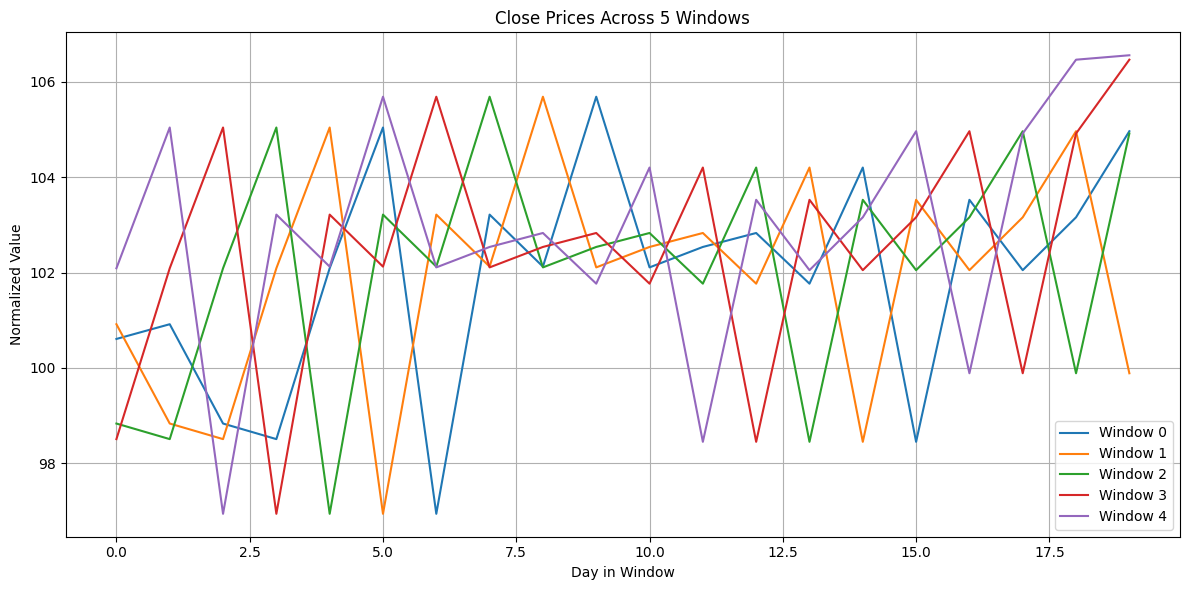

In [ ]:
plot_ohlcv_windows(ohlcv_tensor, num_samples=5, feature_index=3)  # 3 = Close prices

In [ ]:
import plotly.graph_objects as go
import pandas as pd

In [ ]:
def plot_candlestick_window(windows_tensor, window_index=0):
    """
    Plot a candlestick chart for a single 20-day OHLCV window using Plotly.

    Args:
        windows_tensor (torch.Tensor): Tensor of shape [num_windows, window_size, 5]
        window_index (int): Index of the window to visualize
    """
    assert 0 <= window_index < windows_tensor.shape[0], "Invalid window index."

    window = windows_tensor[window_index].numpy()
    df_window = pd.DataFrame(window, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

    fig = go.Figure(data=[go.Candlestick(
        x=list(range(len(df_window))),
        open=df_window['Open'],
        high=df_window['High'],
        low=df_window['Low'],
        close=df_window['Close']
    )])

    fig.update_layout(
        title=f'Candlestick Chart - Window {window_index}',
        xaxis_title='Day in Window',
        yaxis_title='Normalized Price',
        xaxis_rangeslider_visible=False,
        template='plotly_dark'
    )
    fig.show()


In [ ]:
plot_candlestick_window(ohlcv_tensor, window_index=100)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class IndicatorEncoder(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, intermediate_dim=128):
        """
        Encodes OHLCV sequences using a two-layer MLP.

        Args:
            input_dim (int): Number of input features per time step (e.g., 5 for OHLCV)
            hidden_dim (int): Final embedding dimension (e.g., 64)
            intermediate_dim (int): Size of intermediate layer (default: 128)
        """
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, intermediate_dim),
            nn.ReLU(),
            nn.Linear(intermediate_dim, hidden_dim)
        )

    def forward(self, x):
        """
        Forward pass for the encoder.

        Args:
            x (torch.Tensor): Shape [batch_size, seq_len, input_dim]

        Returns:
            torch.Tensor: Shape [batch_size, seq_len, hidden_dim]
        """
        return self.mlp(x)

In [ ]:
# Assume ohlcv_tensor has shape [346, 20, 5]
# Each sample is 20 days of OHLCV data

encoder = IndicatorEncoder(input_dim=5, hidden_dim=64)

# Encode
with torch.no_grad():
    embedded_ohlcv = encoder(ohlcv_tensor)  # [346, 20, 64]

print("Encoded shape:", embedded_ohlcv.shape)


Encoded shape: torch.Size([346, 20, 64])


In [ ]:
import numpy as np
import torch
from tqdm import tqdm

def generate_labeled_windows(num_windows=10000, window_size=20):
    """
    Generate labeled OHLCV windows for upward and downward trends.

    Returns:
        X (torch.Tensor): Shape [num_windows, window_size, 5]
        y (torch.Tensor): Shape [num_windows]
    """
    num_each_class = num_windows // 2
    all_windows = []
    all_labels = []

    for trend, label in [('up', 1), ('down', 0)]:
        print(f"Generating {num_each_class} windows for trend: {trend}")
        windows_collected = 0
        while windows_collected < num_each_class:
            # Generate at least enough days to get multiple windows
            df = generate_synthetic_ohlcv(
                num_days=200,
                initial_price=100,
                volatility=0.01 + 0.01 * np.random.rand(),
                trend_direction=trend,
                slope=2
            )

            # Convert to tensor
            ohlcv_tensor = prepare_ohlcv_for_msgca_windowwise(df, window_size=window_size)
            available = ohlcv_tensor.shape[0]

            # Keep only needed
            needed = min(num_each_class - windows_collected, available)
            all_windows.append(ohlcv_tensor[:needed])
            all_labels.append(torch.full((needed,), label, dtype=torch.long))

            windows_collected += needed

    # Concatenate all
    X = torch.cat(all_windows, dim=0)
    y = torch.cat(all_labels, dim=0)

    print(f"Final dataset shape: X={X.shape}, y={y.shape}")
    return X, y


In [ ]:
ohlcv, y = generate_labeled_windows(num_windows=20000, window_size=100)

# Sample check
print("X shape:", ohlcv.shape)  # [10000, 20, 5]
print("y distribution:", torch.bincount(y))

Generating 10000 windows for trend: up
Generating 10000 windows for trend: down
Final dataset shape: X=torch.Size([20000, 100, 5]), y=torch.Size([20000])
X shape: torch.Size([20000, 100, 5])
y distribution: tensor([10000, 10000])


In [ ]:
import matplotlib.pyplot as plt
import random

def plot_sample_windows(X, y, num_samples=6, feature_index=3):
    """
    Plot sample OHLCV windows by label, showing one feature (e.g. Close prices).

    Args:
        X (torch.Tensor): Shape [N, 20, 5]
        y (torch.Tensor): Shape [N]
        num_samples (int): Number of windows to plot
        feature_index (int): Feature index (0=Open, 1=High, 2=Low, 3=Close, 4=Volume)
    """
    feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']
    assert X.shape[0] >= num_samples, "Not enough samples to plot"

    plt.figure(figsize=(12, 6))
    indices = random.sample(range(X.shape[0]), num_samples)

    for idx in indices:
        label = y[idx].item()
        color = 'green' if label == 1 else 'red'
        label_str = 'Upward' if label == 1 else 'Downward'
        series = X[idx, :, feature_index].numpy()
        plt.plot(series, label=f'{label_str} (idx {idx})', color=color, alpha=0.7)

    plt.title(f'Sample {feature_names[feature_index]} Series from Windows')
    plt.xlabel('Day in Window')
    plt.ylabel('Normalized Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


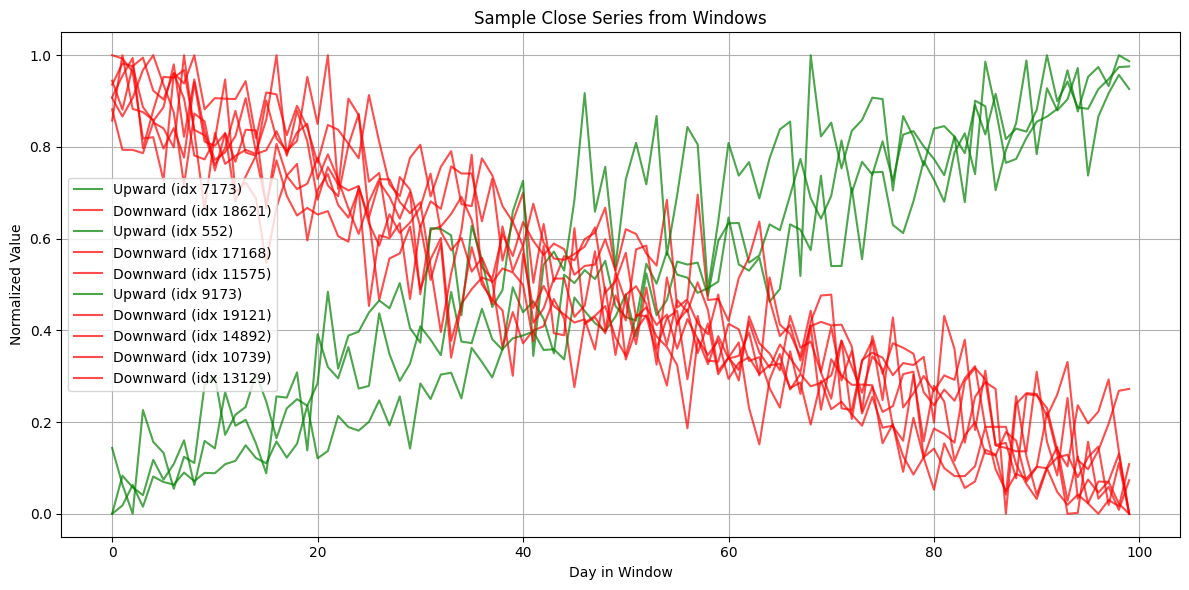

In [ ]:
plot_sample_windows(ohlcv, y, num_samples=10, feature_index=3)  # 3 = Close

In [ ]:
sentiment_embeddings, sentiment_labels, sentiment_centers = generate_sentiment_embeddings(num_samples=20000, class_separation=0.5)

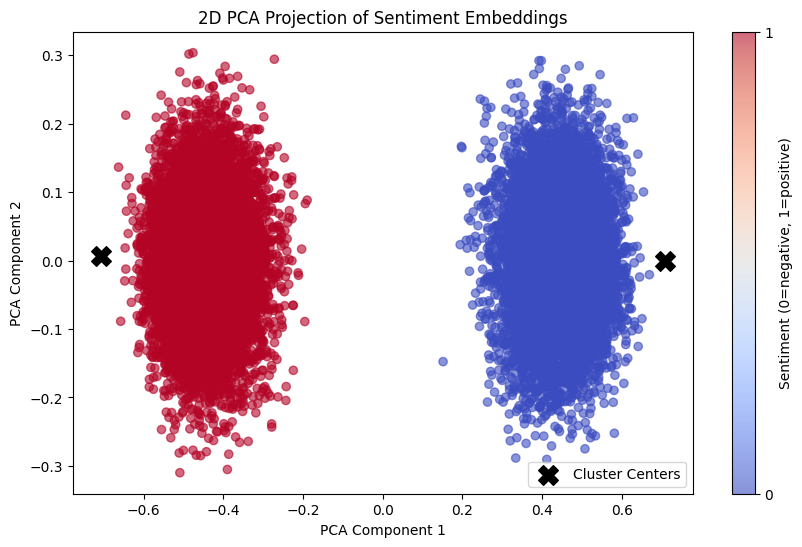

In [ ]:
visualize_embeddings(sentiment_embeddings, sentiment_labels)

| Trend | Cluster | Label |
| ----- | ------- | ----- |
| Down  | 0       | 0     |
| Down  | 1       | 1     |
| Up    | 0       | 2     |
| Up    | 1       | 3     |


In [ ]:
def combine_data_with_labels(X, y, embeddings, labels):
    """
    Combine OHLCV data (X, y) with sentiment embeddings (embeddings, labels) and assign new labels.

    Args:
        X (torch.Tensor): OHLCV data, shape [num_samples, window_size, 5]
        y (torch.Tensor): OHLCV trend labels, shape [num_samples]
        embeddings (numpy.ndarray or torch.Tensor): Sentiment embeddings, shape [num_samples, embedding_size]
        labels (torch.Tensor): Sentiment cluster labels, shape [num_samples]

    Returns:
        combined_data (torch.Tensor): Concatenated embeddings and OHLCV data, shape [num_samples, window_size, 5 + embedding_size]
        final_labels (torch.Tensor): Final labels based on trend and cluster, shape [num_samples]
    """
    # Convert embeddings to torch.Tensor if they are numpy arrays
    if isinstance(embeddings, np.ndarray):
        embeddings = torch.tensor(embeddings, dtype=torch.float32)

    # Create an empty tensor to store the final labels
    final_labels = torch.zeros_like(y)

    # Map y (trend) and labels (sentiment clusters) to final labels
    for i in range(len(y)):
        if y[i] == 0:  # Down trend
            if labels[i] == 0:
                final_labels[i] = 0  # Down, Cluster 0 -> Label 0
            else:
                final_labels[i] = 1  # Down, Cluster 1 -> Label 1
        else:  # Up trend
            if labels[i] == 0:
                final_labels[i] = 2  # Up, Cluster 0 -> Label 2
            else:
                final_labels[i] = 3  # Up, Cluster 1 -> Label 3

    # Reshape embeddings to match the dimensionality of the OHLCV data (num_samples, window_size, embedding_size)
    embeddings_expanded = embeddings.unsqueeze(1).expand(-1, X.shape[1], -1)  # Expand embeddings to match window size

    # Concatenate the OHLCV data with the embeddings
    combined_data = torch.cat((X, embeddings_expanded), dim=-1)  # Combine along the last dimension

    return combined_data, final_labels

In [ ]:
_, final_labels = combine_data_with_labels(ohlcv, y, sentiment_embeddings, sentiment_labels)

# Check the shapes
print(f"Final labels shape: {final_labels.shape}")  # Should be [20000]

Final labels shape: torch.Size([20000])


In [ ]:
final_labels.unique()

tensor([0, 1, 2, 3])

In [ ]:
encoder = IndicatorEncoder(input_dim=5, hidden_dim=64)

# Encode
with torch.no_grad():
    embedded_ohlcv = encoder(ohlcv)  # [10000, 20, 64]

print("Encoded shape:", embedded_ohlcv.shape)

Encoded shape: torch.Size([20000, 100, 64])


In [ ]:
# --- 3) Combine OHLCV + embeddings and assign final labels ---
def combine_data_with_labels(X: Tensor,
                             y_trend: Tensor,
                             embeddings: Tensor,
                             clusters: Tensor):
    # Vectorized mapping to 4 classes:
    # 0 = down & cluster0, 1 = down & cluster1, 2 = up & cluster0, 3 = up & cluster1
    final_labels = torch.where(
        (y_trend==0)&(clusters==0), 0,
        torch.where((y_trend==0)&(clusters==1), 1,
            torch.where((y_trend==1)&(clusters==0), 2, 3)
        )
    )
    # Expand embeddings along time dimension
    B, L, _ = X.shape
    emb_exp = embeddings.unsqueeze(1).expand(B, L, -1)  # (B, L, embed_dim)

    # Concatenate along feature axis
    combined = torch.cat([X, emb_exp], dim=-1)  # (B, L, 5 + embed_dim)
    return combined, final_labels


In [ ]:
d_model = 64  # should match your embedding + indicator feature dim
n_heads = 4
num_classes = 4
batch_size = 64
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class SentimentProjector(nn.Module):
    def __init__(self, input_dim=128, output_dim=64):
        super().__init__()
        self.project = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # x: [batch_size, 128]
        x = self.project(x)  # -> [batch_size, 64]
        x = x.unsqueeze(1).repeat(1, 100, 1)  # -> [batch_size, 20, 64]
        return x


Generating 10000 windows for trend: up
Generating 10000 windows for trend: down
Final dataset shape: X=torch.Size([20000, 100, 5]), y=torch.Size([20000])
4-way distribution: {np.int64(0): np.int64(5099), np.int64(1): np.int64(4901), np.int64(2): np.int64(4901), np.int64(3): np.int64(5099)}


/tmp/ipython-input-163-1439483394.py:24: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-163-1439483394.py:25: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-163-1439483394.py:26: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-163-1439483394.py:38: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-163-1439483394.py:41: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

Epoch 1: 49.00%
Epoch 2: 50.00%
Epoch 3: 51.00%
Epoch 4: 50.00%
Epoch 5: 48.98%
Epoch 6: 50.90%
Epoch 7: 51.18%
Epoch 8: 51.02%
Epoch 9: 49.78%
Epoch 10: 50.05%


<Figure size 500x500 with 0 Axes>

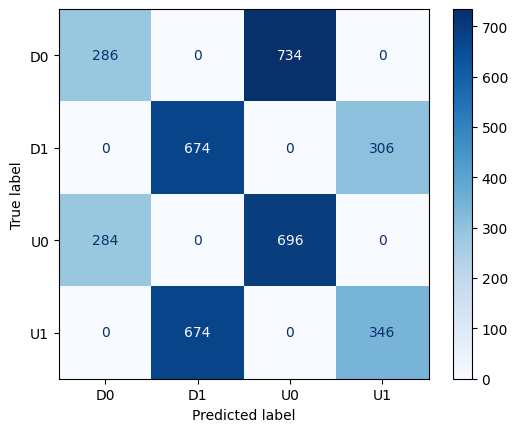

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# --- 1) Generate synthetic data ---
N, WINDOW = 20000, 100
sent_emb, sent_labels, _ = generate_sentiment_embeddings(
    num_samples=N, class_separation=0.5, random_state=42
)
ohlcv, y_binary = generate_labeled_windows(num_windows=N, window_size=WINDOW)

# 4-way labels
final_labels = np.where(
    (y_binary==0)&(sent_labels==0), 0,
    np.where((y_binary==0)&(sent_labels==1), 1,
    np.where((y_binary==1)&(sent_labels==0), 2, 3))
)
print("4-way distribution:", dict(zip(*np.unique(final_labels, return_counts=True))))

# Train/test split
Xo_tr, Xo_te, Se_tr, Se_te, y_tr, y_te = train_test_split(
    ohlcv, sent_emb, final_labels,
    test_size=0.2, stratify=final_labels, random_state=42
)

# --- 2) To torch tensors ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtr = torch.tensor(Xo_tr, dtype=torch.float32, device=device)   # (Ntr, WINDOW, 5)
Str = torch.tensor(Se_tr, dtype=torch.float32, device=device)    # (Ntr, E_raw)
ytr = torch.tensor(y_tr, dtype=torch.long, device=device)        # (Ntr,)
Xte = torch.tensor(Xo_te, dtype=torch.float32, device=device)
Ste = torch.tensor(Se_te, dtype=torch.float32, device=device)
yte = torch.tensor(y_te, dtype=torch.long, device=device)

train_loader = DataLoader(TensorDataset(Xtr, Str, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, Ste, yte), batch_size=64)

# --- 3) Fusion module with automatic expand of 2D→3D or 3D→2D ---
class GatedCrossAttentionFusion(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        self.d_model, self.n_heads = d_model, n_heads
        self.head_dim = d_model // n_heads

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)

        self.unstable_proj = nn.Linear(d_model, d_model)
        self.gate_proj     = nn.Linear(d_model, d_model)
        self.out_proj      = nn.Linear(d_model, d_model)

    def forward(self, primary: torch.Tensor, auxiliary: torch.Tensor):
        # Auto-expand so dims match
        if primary.dim()==3 and auxiliary.dim()==2:
            auxiliary = auxiliary.unsqueeze(1).expand(-1, primary.size(1), -1)
        if primary.dim()==2 and auxiliary.dim()==3:
            primary = primary.unsqueeze(1).expand(-1, auxiliary.size(1), -1)

        # Now both are either 3D or 2D
        if primary.dim()==3:
            B, L, D = primary.shape
            p = primary.reshape(B*L, D)
            a = auxiliary.reshape(B*L, D)
            fused = self._fuse_2d(p, a)
            return fused.view(B, L, D)
        else:
            return self._fuse_2d(primary, auxiliary)

    def _fuse_2d(self, p, a):
        # Q/K/V → (N, heads, head_dim)
        Q = self.q_proj(p).view(-1, self.n_heads, self.head_dim)
        K = self.k_proj(a).view(-1, self.n_heads, self.head_dim)
        V = self.v_proj(a).view(-1, self.n_heads, self.head_dim)

        scores  = torch.matmul(Q, K.transpose(-2,-1)) / (self.head_dim**0.5)
        weights = torch.softmax(scores, dim=-1)
        attn    = torch.matmul(weights, V).view(-1, self.d_model)

        unstable= self.unstable_proj(attn)
        gate    = torch.sigmoid(self.gate_proj(p))
        return self.out_proj(unstable * gate)

class MSGCAFusion(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.fuse = GatedCrossAttentionFusion(d_model, n_heads)
    def forward(self, indicators, documents):
        return self.fuse(indicators, documents)

# --- 4) Encoder & Predictor ---
class DeepIndicatorEncoder(nn.Module):
    def __init__(self, feat_dim, d_model, n_layers=3, n_heads=4):
        super().__init__()
        self.linear = nn.Linear(feat_dim, d_model)
        layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=n_layers)
    def forward(self, x):
        return self.encoder(self.linear(x))

class StockPredictor(nn.Module):
    def __init__(self, feat_dim, raw_doc_dim, d_model, n_heads, num_classes):
        super().__init__()
        self.encoder  = DeepIndicatorEncoder(feat_dim, d_model)
        self.doc_proj = nn.Linear(raw_doc_dim, d_model)
        self.fusion   = MSGCAFusion(d_model, n_heads)
        self.time_mlp = nn.Sequential(
            nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Linear(d_model//2,1)
        )
        self.head     = nn.Linear(d_model, num_classes)

    def forward(self, ohlcv, docs):
        ind = self.encoder(ohlcv)                   # (B, L, d_model)
        doc = self.doc_proj(docs)                   # (B, d_model)
        fused = self.fusion(ind, doc)               # (B, L, d_model)
        scores = self.time_mlp(fused)               # (B, L, 1)
        weights= torch.softmax(scores, dim=1)
        agg    = (fused * weights).sum(1)            # (B, d_model)
        return self.head(agg)                       # (B, num_classes)

# --- 5) Train & evaluate ---
raw_doc_dim = sent_emb.shape[1]
model = StockPredictor(5, raw_doc_dim, 64, 4, 4).to(device)
opt   = optim.Adam(model.parameters(), lr=1e-3)
crit  = nn.CrossEntropyLoss()

for ep in range(1, 11):
    model.train()
    for xo, xe, lbl in train_loader:
        opt.zero_grad()
        logits = model(xo, xe)
        crit(logits, lbl).backward()
        opt.step()
    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for xo, xe, lbl in test_loader:
            p = model(xo, xe).argmax(1)
            all_p.extend(p.cpu().tolist())
            all_t.extend(lbl.cpu().tolist())
    acc = accuracy_score(all_t, all_p)
    print(f"Epoch {ep}: {acc*100:.2f}%")

cm = confusion_matrix(all_t, all_p)
disp = ConfusionMatrixDisplay(cm, display_labels=["D0","D1","U0","U1"])
plt.figure(figsize=(5,5))
disp.plot(values_format='d', cmap='Blues')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import numpy as np

# --- 0) Your data generators (already in your notebook) ---
#    generate_sentiment_embeddings(num_samples, embedding_dim=128,
#                                  class_separation=1.0, random_state=None)
#    generate_labeled_windows(num_windows, window_size)

# --- 1) Generate the synthetic data properly using keyword args ---
N = 20000
WINDOW = 100

# Only override class_separation; leave embedding_dim at its default integer value
sentiment_embeddings, sentiment_labels, sentiment_centers = generate_sentiment_embeddings(
    num_samples=N,
    class_separation=0.5,
    random_state=42
)

# Trend windows: returns ohlcv shape (N, WINDOW, 5) and binary y ∈ {0,1}
ohlcv, y_binary = generate_labeled_windows(num_windows=N, window_size=WINDOW)

# --- 2) Build 4-way labels down+0→0, down+1→1, up+0→2, up+1→3 ---
final_labels = np.where((y_binary == 0) & (sentiment_labels == 0), 0,
                np.where((y_binary == 0) & (sentiment_labels == 1), 1,
                np.where((y_binary == 1) & (sentiment_labels == 0), 2, 3)))
print("4-way distribution:", dict(zip(*np.unique(final_labels, return_counts=True))))

# --- 3) Train/test split on raw arrays ---
X_tr_o, X_te_o, S_tr, S_te, y_tr, y_te = train_test_split(
    ohlcv, sentiment_embeddings, final_labels,
    test_size=0.2, stratify=final_labels, random_state=42
)

# --- 4) Convert to torch Tensors on GPU/CPU ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtr = torch.tensor(X_tr_o, dtype=torch.float32, device=device)  # (train_N, WINDOW, 5)
Str = torch.tensor(S_tr,     dtype=torch.float32, device=device)  # (train_N, emb_dim)
ytr = torch.tensor(y_tr,     dtype=torch.long,    device=device)  # (train_N,)

Xte = torch.tensor(X_te_o, dtype=torch.float32, device=device)
Ste = torch.tensor(S_te,    dtype=torch.float32, device=device)
yte = torch.tensor(y_te,    dtype=torch.long,    device=device)

# --- 5) DataLoaders ---
bs = 64
train_loader = DataLoader(TensorDataset(Xtr, Str, ytr), batch_size=bs, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, Ste, yte), batch_size=bs, shuffle=False)

# --- 6) Simple MLP sanity‐check model ---
class SimplePredictor(nn.Module):
    def __init__(self, window_size, feat_dim, emb_dim, hidden=128, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                       # flatten Xtr: (B, window_size*feat_dim)
            nn.Linear(window_size*feat_dim + emb_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x, emb):
        # x: (B, WINDOW, feat_dim), emb: (B, emb_dim)
        B = x.size(0)
        flat_x = x.reshape(B, -1)
        inp    = torch.cat([flat_x, emb], dim=1)
        return self.net(inp)

# Instantiate
feat_dim = Xtr.size(-1)   # 5
emb_dim  = Str.size(-1)   # as generated
model = SimplePredictor(WINDOW, feat_dim, emb_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# --- 7) Train sanity‐check MLP ---
for epoch in range(1, 6):
    model.train()
    for x, emb, lbl in train_loader:
        optimizer.zero_grad()
        logits = model(x, emb)
        loss   = criterion(logits, lbl)
        loss.backward()
        optimizer.step()

# --- 8) Evaluate ---
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for x, emb, lbl in test_loader:
        preds = model(x, emb).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(lbl.cpu().numpy())

acc = accuracy_score(all_true, all_preds)
print(f"📊 Simple MLP Test Accuracy: {acc*100:.2f}%")


Generating 10000 windows for trend: up
Generating 10000 windows for trend: down
Final dataset shape: X=torch.Size([20000, 100, 5]), y=torch.Size([20000])
4-way distribution: {np.int64(0): np.int64(5099), np.int64(1): np.int64(4901), np.int64(2): np.int64(4901), np.int64(3): np.int64(5099)}


/tmp/ipython-input-146-3650410517.py:30: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-146-3650410517.py:31: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-146-3650410517.py:32: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/tmp/ipython-input-146-3650410517.py:43: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-146-3650410517.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(s

📊 Simple MLP Test Accuracy: 100.00%


In [ ]:
# 1) Make sure you still have your original binary trend labels stored somewhere—
#    e.g. in a variable `y_binary` of shape (N,), values {0,1}
#    (Not `final_labels` which is your 4-way target!)

# If your original up/down labels are in `y`:
y_binary = y.cpu()  # should be length N, values 0 or 1

# 2) Your sentiment cluster labels:
#    if they're a numpy array, wrap them as a tensor:
if isinstance(sentiment_labels, np.ndarray):
    sent_cluster = torch.tensor(sentiment_labels, dtype=torch.long)
else:
    sent_cluster = sentiment_labels.cpu().long()

# 3) Unique values
print("Unique up/down trend labels:", torch.unique(y_binary).tolist())
print("Unique sentiment clusters:   ", torch.unique(sent_cluster).tolist())

# 4) Cross-counts: for each trend value, how many in each cluster?
for trend_val in (0, 1):
    mask = (y_binary == trend_val)
    counts = torch.bincount(sent_cluster[mask], minlength=2)
    print(f"Trend={trend_val} → cluster counts:", counts.tolist())


Unique up/down trend labels: [0, 1, 2, 3]
Unique sentiment clusters:    [0, 1]
Trend=0 → cluster counts: [5099, 0]
Trend=1 → cluster counts: [0, 4901]


In [ ]:
y_cpu

tensor([2, 2, 2,  ..., 0, 0, 0])

In [ ]:
sent_cpu

tensor([0, 0, 0,  ..., 0, 0, 0])

In [ ]:
mport matplotlib.pyplot as plt

# Take the first sample of each class
for cls in range(4):
    idx = (final_labels==cls).nonzero()[0].item()
    window = combined_X[idx].cpu().numpy()   # shape (L, 5+E)
    plt.figure(figsize=(4,2))
    plt.plot(window[:,0], label='open')
    plt.plot(window[:,1], label='high')
    plt.title(f"Class {cls} example")
    plt.legend()
    plt.show()


NameError: name 'combined_X' is not defined

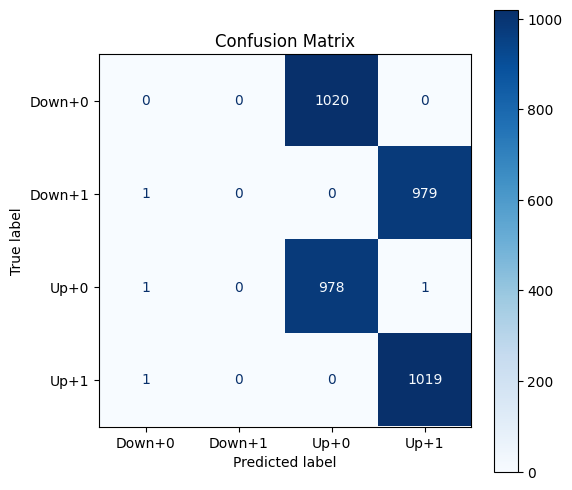

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds, all_true = [], []
model.eval()
with torch.no_grad():
    for ind, doc, labels in test_loader:
        ind, doc = ind.to(device), doc.to(device)
        logits   = model(ind, doc)
        preds    = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true .extend(labels.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(cm,
                              display_labels=["Down+0", "Down+1", "Up+0", "Up+1"])
plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Convert 4-class labels to binary: 0 = Down (0,1), 1 = Up (2,3)
binary_labels = [0 if label in [0, 1] else 1 for label in final_labels]
binary_labels = torch.tensor(binary_labels)

# 2. Convert embedded OHLCV to tensor
embedded_tensor = torch.tensor(embedded_ohlcv, dtype=torch.float32)  # [10000, 100, 64]

# 3. Classifier using precomputed OHLCV embeddings
class OHLCVCNNClassifier(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 2)  # binary classification

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [batch, embed_dim, seq_len]
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.global_pool(x).squeeze(-1)  # [batch, 64]
        return self.fc(x)

# 4. Dataset and DataLoader
dataset = TensorDataset(embedded_tensor, binary_labels)
train_size = int(0.8 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# 5. Training
model = OHLCVClassifier()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

# 6. Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(y_batch.tolist())

# 7. Classification Report
print(classification_report(all_labels, all_preds, target_names=["Down", "Up"]))

# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("OHLCV Binary Confusion Matrix")
plt.show()


/tmp/ipython-input-82-3006286949.py:14: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



NameError: name 'OHLCVClassifier' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 100%

Using device: cuda


/tmp/ipython-input-83-2468475475.py:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipython-input-83-2468475475.py:18: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1 | Loss: 71.2655
Epoch 2 | Loss: 1.4162
Epoch 3 | Loss: 0.3811
Epoch 4 | Loss: 0.1570
Epoch 5 | Loss: 0.0830
Epoch 6 | Loss: 0.0507
Epoch 7 | Loss: 0.0337
Epoch 8 | Loss: 0.0236
Epoch 9 | Loss: 0.0172
Epoch 10 | Loss: 0.0130

Classification Report:
              precision    recall  f1-score   support

        Down       1.00      1.00      1.00      2021
          Up       1.00      1.00      1.00      1979

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



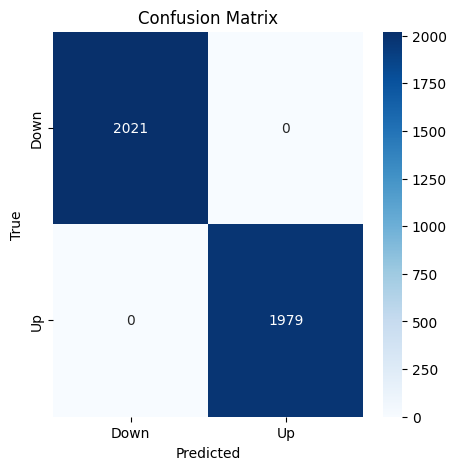

In [ ]:
# 1. Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


binary_labels = [0 if label in [0, 1] else 1 for label in final_labels]
binary_labels = torch.tensor(binary_labels)
X_tensor = torch.tensor(ohlcv, dtype=torch.float32)
y_tensor = torch.tensor(binary_labels, dtype=torch.long)

# 4. Dataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_set, test_set = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

# 5. Transformer-based OHLCV Classifier
class TransformerOHLCVClassifier(nn.Module):
    def __init__(self, input_dim=5, model_dim=64, num_heads=4, num_layers=2, dropout=0.1, max_len=100):
        super().__init__()
        self.embeddings = None
        self.input_proj = nn.Linear(input_dim, model_dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, model_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.ReLU(),
            nn.Linear(model_dim, 2)
        )

    def forward(self, x):
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :x.size(1), :]
        self.embeddings = self.transformer_encoder(x)
        self.embeddings = self.embeddings.mean(dim=1)
        return self.classifier(self.embeddings)

    def get_embedding(self, x):
        x = self.input_proj(x)
        x = x + self.pos_embedding[:, :x.size(1), :]
        embeddings = self.transformer_encoder(x)
        embeddings = embeddings.mean(dim=1)  # Pooling
        return embeddings

# 6. Model, Optimizer, Loss
model = TransformerOHLCVClassifier(input_dim=5, model_dim=64, num_heads=4, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# 7. Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")

# 8. Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(y_batch.cpu().tolist())

# 9. Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Down", "Up"]))

# 10. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

input shape: [batch_size, sequence_length, input_dim]

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        embeddings = model.get_embedding(X_batch)
        print(f"Embedding shape: {embeddings.shape}")
        break  # Just print the shape for one batch

Embedding shape: torch.Size([64, 64])


In [ ]:
input_ohlcv = torch.randn(32, 100, 5).to(device)  # Example batch: 32 samples, 100 time steps, 5 features

# Get OHLCV embeddings from your transformer model
ohlcv_embeddings = model.get_embedding(input_ohlcv)  # Shape: (32, 100, 64)

print(ohlcv_embeddings.shape)

torch.Size([32, 64])


In [ ]:
# Create the model and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fusion_model = MSGCAFusion(d_model=64, n_heads=4).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss

# Sample DataLoader (Replace with actual data)
batch_size = 32
X_train = torch.randn(100, 64).to(device)  # Example training data (adjust for your use case)
y_train = torch.randint(0, 4, (100,)).to(device)  # Example labels (4 classes)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(10):
    fusion_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        # Use the same input data for all three modalities (indicators, documents, graph)
        logits = fusion_model(X_batch, X_batch, X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")


TypeError: MSGCAFusion.forward() takes 3 positional arguments but 4 were given

In [ ]:
# Assuming you already have the transformer embeddings for indicators
# Generate constant graph embedding (replace `num_samples` and `seq_len` with the actual dimensions)
num_samples = 5000  # Adjust according to your dataset
seq_len = 64        # Adjust the sequence length to match your transformer input/output size
d_model = 64        # Adjust this to match the model's embedding dimension

# Generate graph embedding (constant embeddings)
ohlcv, y = generate_labeled_windows(num_windows=num_samples, window_size=100)

graph_embeddings = generate_constant_graph_embedding(num_samples, seq_len, d_model)

# Generate sentiment embeddings
sentiment_embeddings, sentiment_labels, _ = generate_sentiment_embeddings(num_samples=num_samples, embedding_dim=d_model)

# Assuming `transformer_model` is your trained transformer that generates indicator embeddings
# Let's say the transformer has the following signature:
# transformer_model(X) -> (batch_size, seq_len, d_model) -> Indicator embeddings
indicator_embeddings = model.get_embedding(ohlcv.to(device))  # Use your actual indicator embeddings here

# Now, we have:
# - indicator_embeddings: (num_samples, seq_len, d_model)
# - graph_embeddings: (num_samples, seq_len, d_model)
# - sentiment_embeddings: (num_samples, d_model)

# Ensure all tensors have the same batch size, so we'll reshape them accordingly
# Reshape to match the shape of your model's expected input
indicator_embeddings = indicator_embeddings.view(num_samples, seq_len, d_model)
sentiment_embeddings = sentiment_embeddings.view(num_samples, seq_len, d_model)  # If seq_len is 1
graph_embeddings = graph_embeddings.view(num_samples, seq_len, d_model)


In [ ]:
import torch
import gc

# If using PyTorch
if 'cuda' in str(torch.device('cuda')):
    torch.cuda.empty_cache()

# Force garbage collection
gc.collect()